# Better Hedge Ratio
Steven Xu

In [1]:
import pandas as pd
import numpy as np
from pandas_datareader import data
import matplotlib.pyplot as plt
import quandl
import datetime as dt
quandl.ApiConfig.api_key = "9zu342hfxo1abY1pcd67"
ALPHAVANTAGE_API_KEY = "7GI26HCQ94CQ9SL0"
import seaborn as sns
sns.set()
from sklearn.decomposition import PCA

import statsmodels.api as sm

In [2]:
def download_financial_data(name, source,
                            startdate = '2010-01-01',
                            enddate = '2012-01-01'
#                             startdate = '2018-01-01', 
#                             enddate = dt.date.today()
                           ):
    df = data.DataReader(name, source,startdate, enddate)
    return df

def download_adj_close(name, source, 
                       startdate = '2010-01-01', 
                       enddate = dt.date.today()):
    return download_financial_data(name, source, startdate, enddate)['Adj Close']

We begin with Teetor's approach that spreads should be regressed on level, not return, such that:  
$$s_t = p_t -\beta q_t$$
where $s_t$ is price spread, $\beta$ is the hedge ratio, and $p_t$ and $q_t$ are prices for markets/assets P and Q. We also perform the regressions on the most recent two yeras instead of those in the paper.  
For simplicity's sake, we simplify the above equation to the form:
$$ p_t = s_t + \beta q_t$$

In [3]:
IWM = download_financial_data('IWM', 'yahoo')
VXZ = download_financial_data('VXZ','yahoo')
VIX = download_financial_data('^VIX', 'yahoo')

In [4]:
adjcloses = pd.DataFrame()

In [5]:
adjcloses['IWM'] = IWM['Adj Close']
adjcloses['VXZ'] = VXZ['Adj Close']

In [6]:
def olsHedgeRatio(y, x):
    #p depends on q
    model = sm.OLS(y, sm.add_constant(x)).fit()
    return model.params[1]

def tlsHedgeRatio(pq):
    """p is y, q is x
    """
    pca = PCA().fit(pq)
    #this calculation is necessary to make sure the signs come out the same when the opposite operation is taken. 
    #something is horrifically unintuitive about sklearn's PCA.
    #but this code is fine
    return pca.components_[0,0]/pca.components_[0,1]


In [7]:
b1 = olsHedgeRatio(adjcloses.IWM, adjcloses.VXZ)
b2 = olsHedgeRatio(adjcloses.VXZ, adjcloses.IWM)
b3 = tlsHedgeRatio(adjcloses)
b4 = tlsHedgeRatio(adjcloses.iloc[:,::-1])
print('OLS for IWM vs VXZ:', b1)
print('OLS for VXZ vs IWM:', b2)
print('OLS coefficients multiplied:', b1*b2)
print('TLS for IWM vs VXZ:', b3)
print('TLS for VXZ vs IWM:', b4)
print('TLS coefficients multiplied:', b3*b4)

OLS for IWM vs VXZ: -0.11087091736523441
OLS for VXZ vs IWM: -6.448326461440419
OLS coefficients multiplied: 0.7149318702504152
TLS for IWM vs VXZ: -0.11141032004164546
TLS for VXZ vs IWM: -8.975829165791799
TLS coefficients multiplied: 0.9999999999999999


C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [8]:
pca = PCA().fit(adjcloses)
pcab = PCA().fit(adjcloses.iloc[:,::-1])
print(pca.components_,'\n' ,pcab.components_)

[[-0.11072526  0.99385105]
 [-0.99385105 -0.11072526]] 
 [[ 0.99385105 -0.11072526]
 [-0.11072526 -0.99385105]]


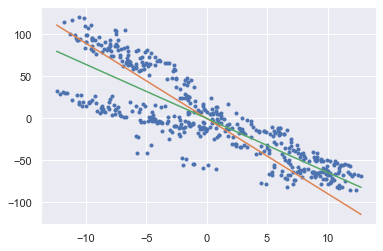

In [9]:
plt.plot(adjcloses.IWM-adjcloses.IWM.mean(), adjcloses.VXZ-adjcloses.VXZ.mean(), '.')
domain = np.array([adjcloses.IWM.min()-adjcloses.IWM.mean(),adjcloses.IWM.max()-adjcloses.IWM.mean()])
plt.plot(domain, b4*domain)
plt.plot(domain, b2*domain)

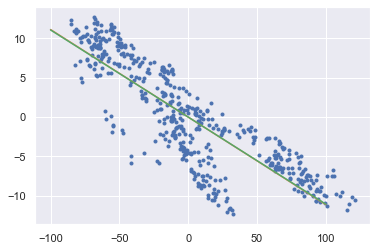

In [10]:
plt.plot(adjcloses.VXZ-adjcloses.VXZ.mean(), adjcloses.IWM-adjcloses.IWM.mean(), '.')
domain = np.array([-100,100])
plt.plot(domain, b3*domain)
plt.plot(domain, b1*domain)

To aid in the future generation of these charts, we define a function plot_beta

In [11]:
def plot_beta(betas, x, y, startdate = '2000-01-01', enddate = dt.date.today()):
    """For a given set of x and y (could be stock, could be returns) and beta,
       plot their relationship."""
    
    x_, y_ = x[startdate:enddate], y[startdate:enddate]
    plt.plot(x_, y_, '.')
    domain = np.array([x_.min(), x_.max()])

    plt.xlabel('{}'.format(x.name))
    plt.ylabel('{}'.format(y.name))
    for beta in betas:
        plt.plot(domain, beta*domain)

## Examples
### Crack Spread

In [12]:
CRUDE = download_adj_close('CL=F', 'yahoo')
#quoted per barrel ~42
GAS = download_adj_close('RB=F', 'yahoo')
#quote per gallon
HEAT = download_adj_close('HO=F', 'yahoo')
#quoted per gallon

In [13]:
GH = pd.DataFrame()
GH['GAS'] = GAS
GH['HEAT'] = HEAT

In [14]:
bgh1 = olsHedgeRatio(GAS, HEAT) #gas on heat
bgh2 = olsHedgeRatio(HEAT, GAS)
bgh3 = tlsHedgeRatio(GH)
bgh4 = tlsHedgeRatio(GH.iloc[:,::-1]) #heat on gas
print(bgh1, bgh2, bgh1*bgh2)
print(bgh3, bgh4, bgh3*bgh4)

0.49398350381530065 1.4847199893900203 0.7334271825434983
0.5313097679193832 1.8821411921636861 0.9999999999999993


C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


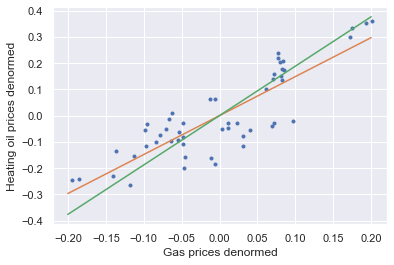

In [15]:
plt.plot(GAS-GAS.mean(), HEAT-HEAT.mean(), '.')
plt.xlabel('Gas prices denormed')
plt.ylabel('Heating oil prices denormed')
domain = np.array([-.2, .2])
plt.plot(domain, bgh2*domain)
plt.plot(domain, bgh4*domain)

In [16]:
CG = pd.DataFrame()

In [17]:
CG['GAS'] = GAS
CG = CG.merge(CRUDE, how = 'left',left_index = True, right_index = True).dropna().rename(columns = {'Adj Close':'CRUDE'})

0.015244501987932323 18.600523331429777 0.2835557149025628
0.01525345641473561 65.5589115548886 1.0


C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


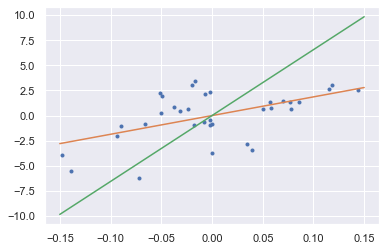

In [18]:
bcg1 = olsHedgeRatio(CG.GAS, CG.CRUDE) #gas on crude
bcg2 = olsHedgeRatio(CG.CRUDE, CG.GAS)
bcg3 = tlsHedgeRatio(CG)#gas on crude
bcg4 = tlsHedgeRatio(CG.iloc[:,::-1])#crude on gas
print(bcg1, bcg2, bcg1*bcg2)
print(bcg3, bcg4, bcg3*bcg4)

plt.plot(CG.GAS-CG.GAS.mean(), CG.CRUDE-CG.CRUDE.mean(), '.')
domain = np.array([-.15,.15])

plt.plot(domain, domain*bcg2)
plt.plot(domain, domain*bcg4)


C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


0.028456442945350383 30.925157652014782 0.8800199843005244
0.028459582402451115 35.13755001246518 0.9999999999999999
0.7363132774289234 0.8366083336301232


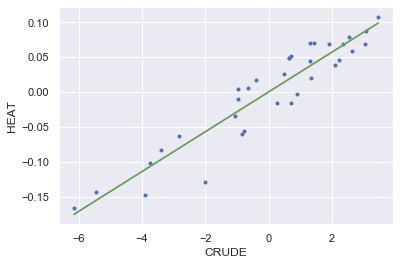

In [57]:
CH = pd.DataFrame()
CH['HEAT'] = HEAT
CH = CH.merge(CRUDE, how = 'left',left_index = True, right_index = True).dropna().rename(columns = {'Adj Close':'CRUDE'})
bch1 = olsHedgeRatio(CH.HEAT, CH.CRUDE)#dependence heat on crude
bch2 = olsHedgeRatio(CH.CRUDE, CH.HEAT)
bch3 = tlsHedgeRatio(CH)# heat on crude
bch4 = tlsHedgeRatio(CH.iloc[:,::-1]) #crude on heat
print(bch1, bch2, bch1*bch2)
print(bch3, bch4, bch3*bch4)
print(bch2/42, bch4/42)

# plt.plot(CH.CRUDE-CH.CRUDE.mean(), CH.HEAT-CH.HEAT.mean(), '.')
domain = np.array([-5,4])

# plt.plot(domain, domain*bcg1)
# plt.plot(domain, domain*bcg3)
plot_beta([bch3, bch1],CH.CRUDE-CH.CRUDE.mean(),CH.HEAT-CH.HEAT.mean())

Via TLS, we can define regressions of:

Heat on gas: bgh4  
Crude on heat: bch4  
Crude on gas: bcg4

Also, crude futures are quoted per barrel of 42 gallons. Heat futures are quoted per gallon. Gas futures are quoted per gallon. We apply these conversions. Converting crude price from per barrel to per gallon is just dividing by 42.

In [20]:
print("Beta for dollar in gallon of gas to dollar in gallon of heating:",bgh4)
print("Beta for dollar in heat contract to dollar in crude contract:", bch4)
print("Beta for dollar in gas contract to dollar in crude contract:", bcg4)
print("OR, if applying gallon convention")
print("Beta for dollar in heat to dollar in gallons of crude", bch4/42)
print("Beta for dollar in gas to dollar in gallons of crude", bcg4/42)
print("Approximate Ratios w heating oil as unit:")
print(2*bcg4/42*bgh4,2*bgh4,2)
print(bcg4/42*bgh4, bgh4,1)

Beta for dollar in gallon of gas to dollar in gallon of heating: 1.8821411921636861
Beta for dollar in heat contract to dollar in crude contract: 35.13755001246518
Beta for dollar in gas contract to dollar in crude contract: 65.5589115548886
OR, if applying gallon convention
Beta for dollar in heat to dollar in gallons of crude 0.8366083336301232
Beta for dollar in gas to dollar in gallons of crude 1.5609264655925856
Approximate Ratios w heating oil as unit:
5.875767997660557 3.7642823843273723 2
2.9378839988302783 1.8821411921636861 1


Apparently the rule that the hedge ratio of crude:gas:heating oil is approximately 3:2:1 or 5:3:2 does not appear to hold, and there is an inconsistency between directly calculating Beta of heating oil to crude vs chaining ratios from heating oil to gas to crude, wihch is dd because you'd expect it to be somewhat internally consistent. For 3:2:1 one would expect ratios of 3, 1.5, or 2, and for 5:3:2, 2.5, 1.5, 1.6. These are not quite what we'd expect, but that's fine -- this is a crack spread on a price.

In [21]:
spreadgh = GH.GAS - bgh4*GH.HEAT

C:\Users\steve\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


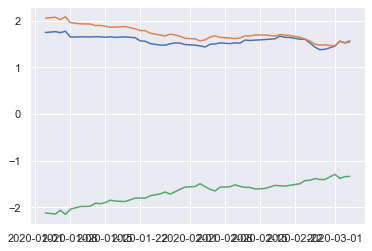

In [22]:
plt.plot(GH.index, GH.GAS)
plt.plot(GH.index, GH.HEAT)
plt.plot(spreadgh)

In [23]:
spreadcg2 = CG.CRUDE - bcg4*CG.GAS

pca = PCA().fit(CH)
pca.components_

SPY = download_adj_close('SPY', 'yahoo')
indices = pd.DataFrame()
indices['SPY'] = SPY
indices['IWM'] = IWM['Adj Close']
indices = indices.dropna()

pca = PCA().fit(indices)
pca.components_[0,0]/pca.components_[0,1], pca.components_[1,0]/pca.components_[1,1], pca.components_[0,0]/pca.components_[1,0], pca.components_[0,1]/pca.components_[1,1]
# pca.components_

pca = PCA().fit(indices.iloc[:,::-1])
pca.components_[0,0]/pca.components_[0,1], pca.components_[1,0]/pca.components_[1,1]
# pca.components_

pca = PCA().fit(adjcloses)
pca.components_

tlsHedgeRatio(indices)

pca.components_[1,0]

pca.components_

array([[-0.11072526,  0.99385105],
       [-0.99385105, -0.11072526]])

Now, we attempt to construct a returns based spread such that:
$$r_{A,t} = \beta r_{B,t} + \epsilon_t$$
and that dollar variation is equal, where V is the dollar value:
$$r_{A,t}V_{a,t} = r_{B,t}V_{B,t}$$
For simplicity's sake we assume that the time t is implicit in the subscript. Let N denote number of units and P denote price.
$$r_A N_A P_A = r_B N_B P_B$$
Then if $N_A$ = 1:
$$N_B = \beta \frac{P_A}{P_B}$$
This will change over time. However, the process of regression itself does not change.

We will look at returns on AAPL & GOOG, IBM & SPY, and DIA & SPY. The only information we need for return-based regression are price and date. We will regress on returns from 2018 to determine a trading strategy for 2019.

After determining $\beta$, we will implement the PnL equation for the purposes of attempting a successful pairs trading strategy.

Implementing the Basic P/L Equation:
$$E_{n+1} = E_n + r\Delta t E_n + \sum_{i=1}^N Q_{i,n}R_{i,n} - r\Delta t\big(|\sum_{i=1}^NQ_{i,n}|\big) - \delta \Delta t \sum_{i=1}^N|Q_{i,n}| - \epsilon \sum_{i=1}^N|Q_{i,n+1}-Q_{i,n}|$$

For this case, we will assume $\delta = 0$ and $\epsilon = .0005$.

That simplifies the equation somewhat:

$$E_{n+1} = E_n(1 + r\Delta t) + \sum_{i=1}^N Q_{i,n}R_{i,n} - r\Delta t\sum_{i=1}^NQ_{i,n}  - \epsilon\sum_{i=1}^N|Q_{i,n+1}-Q_{i,n}|$$

Then we can simplify it even further into terms of shares and price:

$$E_{n+1} = E_n(1 + r\Delta t) + \sum_{i=1}^N N_{i,n}P_{i,n}R_{i,n} - r\Delta t\sum_{i=1}^NN_{i,n}P_{i,n} - \epsilon\sum_{i=1}^N|N_{i,n+1}P_{i,n+1}-N_{i,n}P_{i,n}|$$

$$r_{A,t} = \beta r_{B,t} + \epsilon_t$$

$$N_A = 1, N_B = \beta \frac{P_A}{P_B}N_A$$

Note that a 'depends' on b for the purposes of calculating $\beta$ and units of B.

(so $A = s + \beta B$)

If we net the PnL of two assets A and B, one long and one short, we should get the spread:
$$P_{n+1} = A_{n+1} - \beta B_{n+1}$$ 
$$= (A_n - \beta B_n)(1 + r\Delta t) + ( N_{A,n}P_{A,n}R_{A,n} - N_{A,n}\beta P_{A,n}R_{B,n}) - r\Delta t (N_{A,n}P_{A,n} - N_{A,n}\beta P_{A,n}) - \epsilon(|N_{A, n+1} P_{A, n+1} - N_{A, n} P_{A,n}| - |\beta (N_{A,n+1} P_{A, n+1} - N_{A,n}P_{A,n})|)$$
Analytically, this is a little bit silly.

We will take a naive approach of daily rebalancing such that we are always holding a propelry beta-hedged position in each stock. For this notebook only, we will take the assumption that we are able to buy and sell at the daily close for both stocks.

In [24]:
def PnL(beta, 
        pricesB, pricesA,
        rB, rA,
        rates, 
        gofrom, goto):
    """
    This function implements a naive backtester that rebalances daily.
    for this toy model, we will assume we put 1 unit of wealth into stock A.
     beta should be apparent dependence of a on b, rather than b on a, though with TLS they are symmetrical.
     a is dependent variable. b is independent variable.
    """
    wealth = 0
    epsilon = .0005
    df = pd.DataFrame()
    df['PA'] = pricesA[gofrom:goto]
    df['PB'] = pricesB[gofrom:goto]
    df['rA'] = rA[gofrom:goto]
    df['rB'] = rB[gofrom:goto]
    df['r'] = rates[gofrom:goto]
    df = df.dropna()
    output = pd.DataFrame()
    
    EA = 0
    EB = 0
    
    equity = [wealth]
    posA = [EA]
    posB = [EB]
    
    
    PAold = df.PA[0]
    PBold = df.PB[0]
    NA = 1/PAold #We dollarize PnL by investing $1 into A and going relative to that.
    NBold = beta*PAold/PBold*NA
    
    NBs = [NBold/NA]
    for row in df.iterrows():
        data = row[1]
        PA = data['PA']
        PB = data['PB']
        rA = np.exp(data['rA'])-1
        rB = np.exp(data['rB'])-1
        r = data['r']
        
        NB = beta*PA/PB*NA
        EA = EA*(1 + r) + NA*PAold*(rA - r) - epsilon*np.abs(NA*PA - NA*PAold)
        EB = EB*(1 + r) + NB*PBold*(rB - r) - epsilon*np.abs(NB*PB - NBold*PBold)
        s = EA-beta*(EB + 2*epsilon*np.abs(NB*PB - NBold*PBold))
        PAold, PBold, NBold = PA, PB, NB
        
        posA.append(EA)
        posB.append(-beta*EB)
        NBs.append(NB/NA)
        equity.append(s)
    return posA, posB, equity, NBs

In [25]:
#using the treasury, we shall download daily data for the one-year rate.
from fredapi import Fred
fred = Fred(api_key = '3f1406d5815baa23617199af394d7e02')

In [26]:
oneyear = fred.get_series('DGS1')

In [27]:
# approximate a daily rate from a oneyear rate
oneyear = oneyear.interpolate()/365

We begin with AAPL and GOOG, two tech companies that in theory should have some relation.

In [28]:
AAPL = download_adj_close('AAPL', 'yahoo', startdate = '2010-01-01', enddate = '2020-01-01')
GOOG = download_adj_close('GOOG', 'yahoo', startdate = '2010-01-01', enddate = '2020-01-01')

def get_logreturns(df):
    dt = ((df.index.shift(1,'B')-df.index).to_series().dt.days).values
    return np.log(df/df.shift(1))/np.sqrt(dt)

In [29]:
rAAPL = get_logreturns(AAPL)
rGOOG = get_logreturns(GOOG)
rAAPL.name = 'AAPL'
rGOOG.name = 'GOOG'
AG = pd.DataFrame()
AG['AAPL'] = rAAPL
AG['GOOG'] = rGOOG
AG = AG.dropna()

In [30]:
regfrom = '2018-01-01'
regto = '2019-01-01'
bAGt = tlsHedgeRatio(AG[regfrom:regto])
bAGo = olsHedgeRatio( rGOOG[regfrom:regto],rAAPL[regfrom:regto])


C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


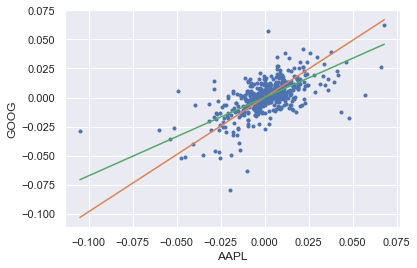

In [31]:
plot_beta([bAGt, bAGo], rAAPL, rGOOG, regfrom)

In [32]:
bAGt, bAGo

(0.9846232479223644, 0.6748859880512239)

PnL: 0.8195910425682436


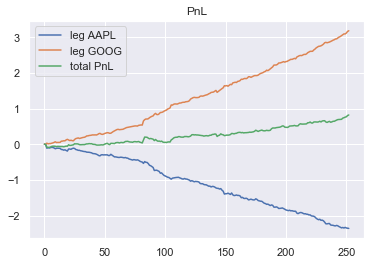

In [33]:
AAPLshares, GOOGshares, E, NBs = PnL(bAGt, GOOG, AAPL, rGOOG, rAAPL, oneyear, '2019-01-01', '2020-01-01')

plt.plot(AAPLshares)
plt.plot(GOOGshares)
plt.plot(E)
plt.title('PnL')
plt.legend(['leg AAPL', 'leg GOOG', 'total PnL'])
print("PnL:", E[-1])

Text(0.5, 1.0, 'Shares of GOOG per shares of AAPL')

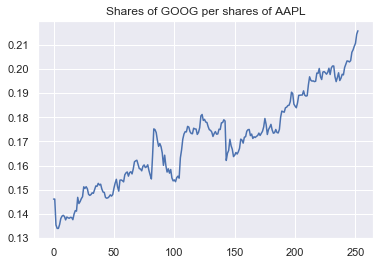

In [34]:
plt.plot(NBs)
plt.title('Shares of GOOG per shares of AAPL')

Next, we consider IBM vs the market/SPY.

In [35]:
IBM = download_adj_close('IBM', 'yahoo')
SPY = download_adj_close('SPY', 'yahoo')
rIBM = get_logreturns(IBM)
rSPY = get_logreturns(SPY)
rIBM.name = 'IBM'
rSPY.name = 'SPY'
IS = pd.DataFrame()

IS['IBM'] = rIBM
IS['SPY'] = rSPY
IS = IS.dropna()

In [36]:
IBM[-1], SPY[-1]

(134.22000122070312, 312.8599853515625)

C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


1.768897975896867 0.9540151903702736


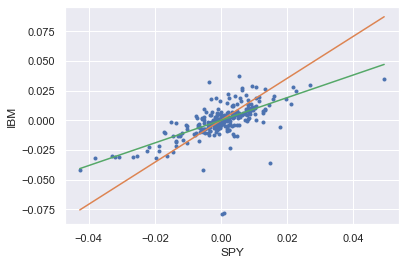

In [37]:
regfrom = '2018-01-01'
regto = '2019-01-01'
bISt = tlsHedgeRatio(IS[regfrom:regto])
bISo = olsHedgeRatio( rIBM[regfrom:regto],rSPY[regfrom:regto])
plot_beta([bISt, bISo], rSPY, rIBM, regfrom, regto)
print(bISt, bISo)

PnL 5.912174706716517


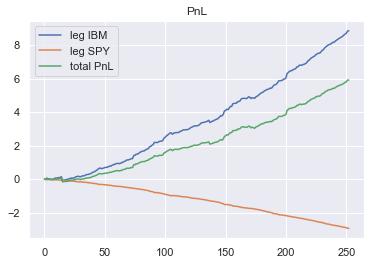

In [38]:
SPYshares, IBMshares,  EIS, NBs = PnL(bISt, IBM, SPY, rIBM, rSPY, oneyear, '2019-01-01', '2020-01-01')

plt.plot(IBMshares)
plt.plot(SPYshares)
plt.plot(EIS)
plt.title('PnL')
plt.legend(['leg IBM', 'leg SPY', 'total PnL'])
print("PnL",EIS[-1])

Text(0.5, 1.0, 'Shares IBM per shares SPY')

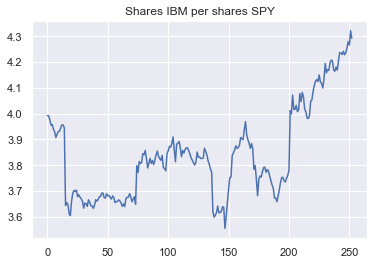

In [39]:
plt.plot(NBs)
plt.title('Shares IBM per shares SPY')

In [40]:
# bSIt = tlsHedgeRatio(IS[regfrom:regto].iloc[:,::-1])

Additionally, we look at the performance of the Dow Jones and the S&P, proxied through ETFs.

In [41]:
DIA = download_adj_close('DIA', 'yahoo')
rDIA = get_logreturns(DIA)
rDIA.name = 'DIA'
DS = pd.DataFrame()

DS['DIA'] = rDIA
DS['SPY'] = rSPY
DS = DS.dropna()

C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


1.0645186849536092 1.0346204081006514


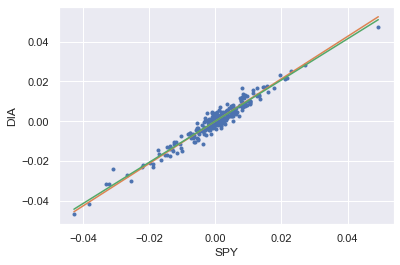

In [42]:
regfrom = '2018-01-01'
regto = '2019-01-01'
bDSt = tlsHedgeRatio(DS[regfrom:regto])
bDSo = olsHedgeRatio( rDIA[regfrom:regto],rSPY[regfrom:regto])
plot_beta([bDSt, bDSo], rSPY, rDIA, regfrom, regto)
print(bDSt, bDSo)

In [43]:
SPYshares, DIAshares, EDS, NBs = PnL(bDSt, DIA, SPY, rDIA, rSPY, oneyear, '2019-01-01', '2020-01-01')

PnL/$:  0.5530955332532113


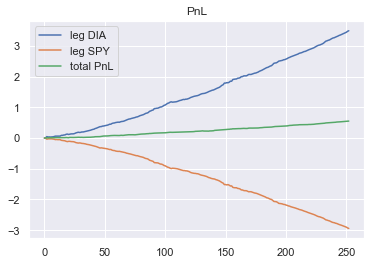

In [44]:
plt.plot(DIAshares)
plt.plot(SPYshares)
plt.plot(EDS)
plt.title('PnL')
plt.legend(['leg DIA', 'leg SPY', 'total PnL'])
print("PnL/$: ",EDS[-1])

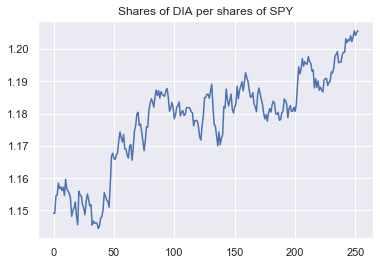

In [45]:
plt.plot(NBs)
plt.title("Shares of DIA per shares of SPY");

We also look at the cryptocurrencies Bitcoin and Ethereum, though this approach may be a bit naive as there may not be a robust market for shorting Bitcoin and Ethereum. It would likely make more sense to trade on futures contracts instead.

In [46]:
BTC = download_adj_close('BTCUSD=X', 'yahoo')
ETH = download_adj_close('ETHUSD=X', 'yahoo')

In [47]:
rBTC = get_logreturns(BTC)
rETH = get_logreturns(ETH)
rBTC.name = 'BTC'
rETH.name = 'ETH'
regfrom = '2016-01-01'
regto = '2019-01-01'
bBEo = olsHedgeRatio(rETH[regfrom:regto], rBTC[regfrom:regto])

BE = pd.DataFrame()


BE['ETH'] = rETH#y
BE['BTC'] = rBTC#x

bBEt = tlsHedgeRatio(BE[regfrom:regto])

C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


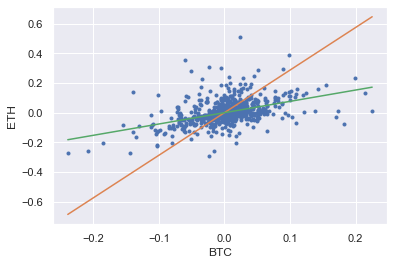

In [48]:
plot_beta([bBEt, bBEo], rBTC, rETH, regfrom, regto)

PnL/$:  49.667279581761434


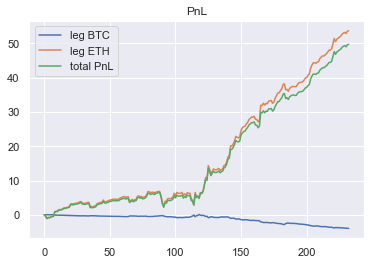

In [49]:
BTCpos, ETHpos, ECC, NBs = PnL(bBEt, ETH, BTC, rETH, rBTC, oneyear, '2019-01-01', '2020-01-01')
plt.plot(BTCpos)
plt.plot(ETHpos)
plt.plot(ECC)
plt.title('PnL')
plt.legend(['leg BTC', 'leg ETH', 'total PnL'])
print("PnL/$: ",ECC[-1])


Text(0.5, 1.0, 'ETH per BTC')

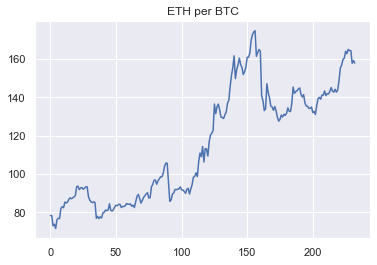

In [50]:
plt.plot(NBs)
plt.title('ETH per BTC')

Just for fun, we compare TQQQ and SQQQ. TQQQ and SQQQ are described as triple leveraged index funds. TQQQ is meant to provide three times the daily returns of QQQ, an ETF consisting of the top 100 nonfinancial firms in the NASDAQ. SQQQ is meant to provide three times negative the daily returns of QQQ.

In [51]:
TQQQ = download_adj_close('TQQQ', 'yahoo')
SQQQ = download_adj_close('SQQQ', 'yahoo')

In [52]:
rTQQQ = get_logreturns(TQQQ)
rSQQQ = get_logreturns(SQQQ)
rTQQQ.name = 'TQQQ'
rSQQQ.name = 'SQQQ'
regfrom = '2018-01-01'
regto = '2019-01-01'
bQQo = olsHedgeRatio(rSQQQ[regfrom:regto], rTQQQ[regfrom:regto])

QQ = pd.DataFrame()


QQ['SQQQ'] = rSQQQ#y
QQ['TQQQ'] = rTQQQ#x

bQQt = tlsHedgeRatio(QQ[regfrom:regto])

C:\Users\steve\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:2542: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


-0.9943437781855072


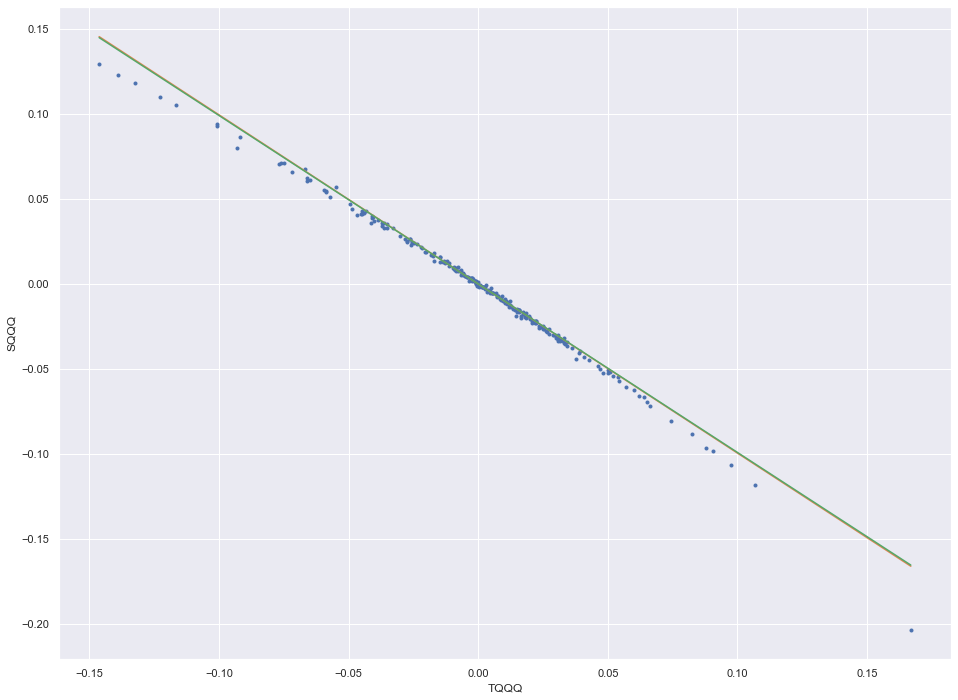

In [53]:
plt.figure(figsize=(16,12))
plot_beta([bQQt, bQQo], rTQQQ, rSQQQ, regfrom, regto)
print(bQQt)

There is a noticeable convexity in the returns of TQQQ and SQQQ. When TQQQ has high returns, SQQQ has higher than expected losses. When TQQQ has poor returns, SQQQ has worse than expected gains. However, this effect only really seems to appear in movements > 5%.

PnL/$:  8.008315596852919


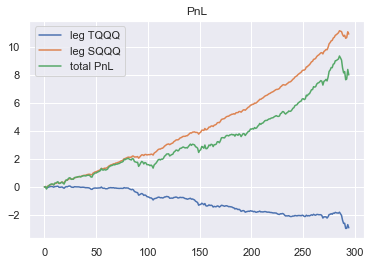

In [54]:
TQQQpos, SQQQpos, EQQ, NBs = PnL(bQQt, SQQQ, TQQQ, rSQQQ, rTQQQ, oneyear, '2019-01-01', dt.date.today())
plt.plot(TQQQpos)
plt.plot(SQQQpos)
plt.plot(EQQ)
plt.title('PnL')
plt.legend(['leg TQQQ', 'leg SQQQ', 'total PnL'])
print("PnL/$: ",EQQ[-1])

Text(0.5, 1.0, 'Shares of SQQQ per TQQQ')

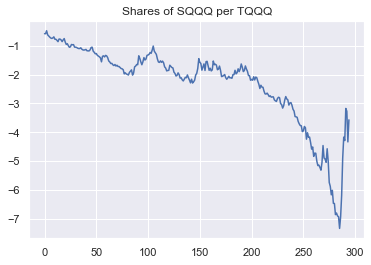

In [55]:
plt.plot(NBs)
plt.title('Shares of SQQQ per TQQQ')

Note that there is a negative $\beta$, as expected, but also a 'negative' amount of shares that should be shorted for every long share. The position in both ETFs will be long.

Also note that this strategy probably won't work in real life because of the difficulty of daily rebalancing and the fact that it's the stupidest way of implementing a beta-neutral strategy you could possibly think of, the 3x leveraged QQQs are meant for trading not investing and I can't think of other reasons it might be a bad idea but I'm not sure why.

inf


C:\Users\steve\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in double_scalars
  del sys.path[0]


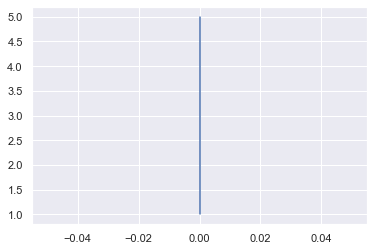

In [56]:
#an aside to show that y goes first in constructing the dataframe/array passed to the tlsHedgeRatio function.

x = np.zeros(5)
y = np.arange(1,6)

xy = pd.DataFrame()
xy['y'] = y
xy['x'] = x


print(tlsHedgeRatio(xy))

plt.plot(x,y)